In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = a06b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

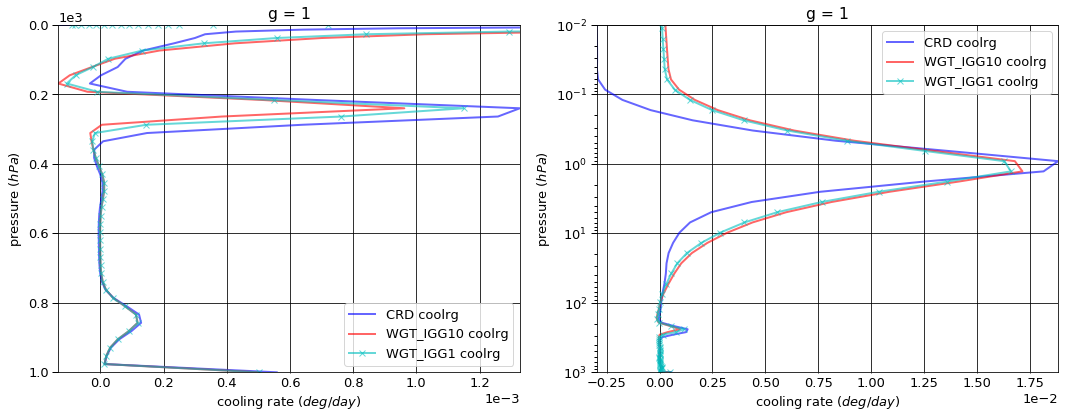

# Figure: cooling rate g-group 2

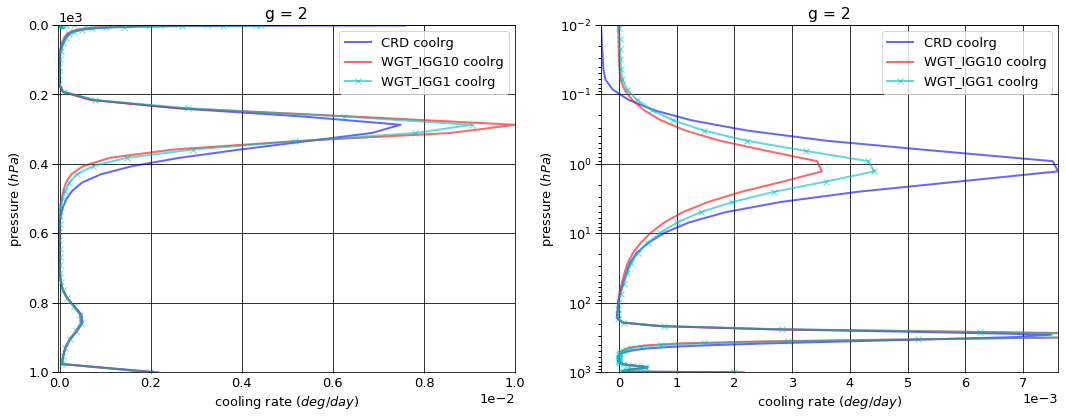

# Figure: cooling rate g-group 3

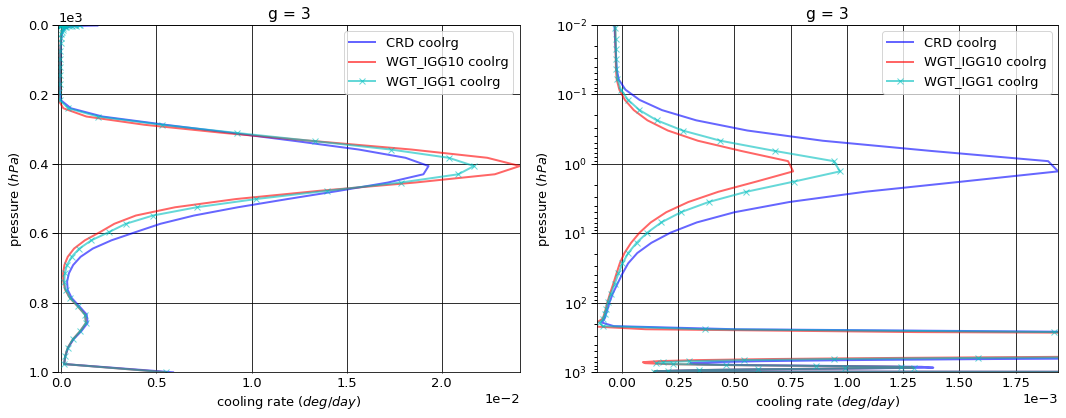

# Figure: cooling rate g-group 4

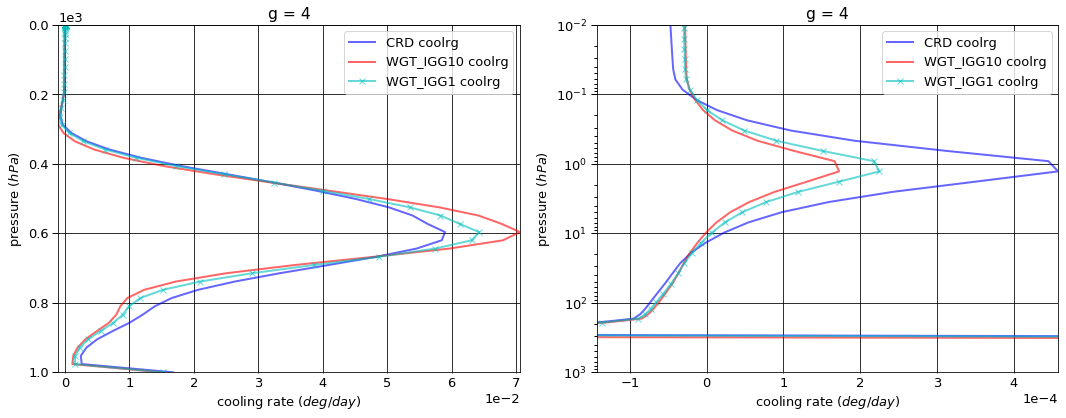

# Figure: cooling rate g-group 5

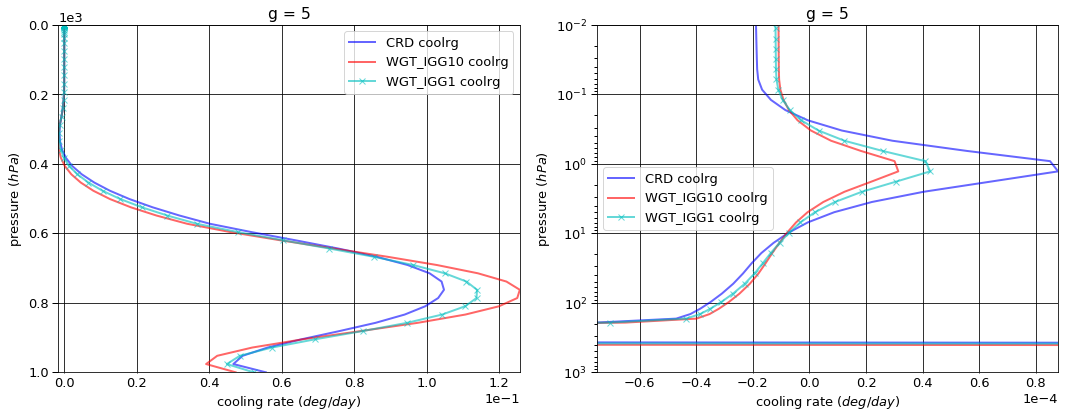

# Figure: cooling rate g-group 6

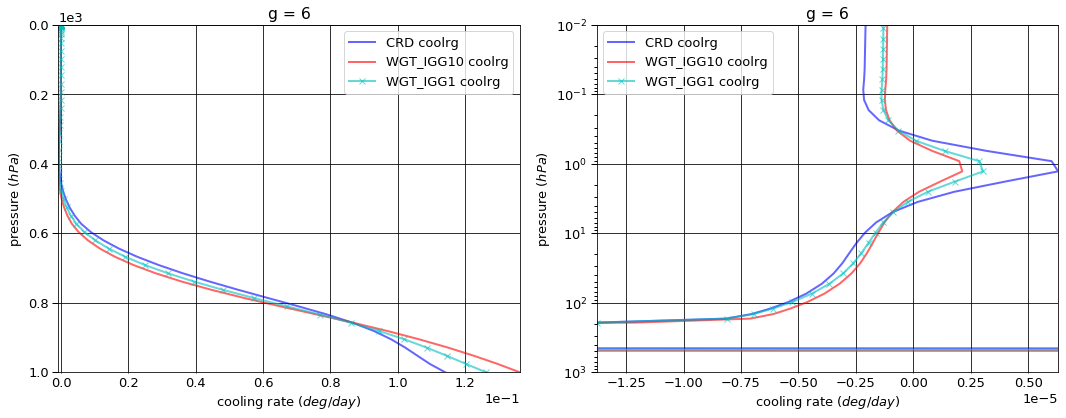

# Figure: cooling rate g-group 7

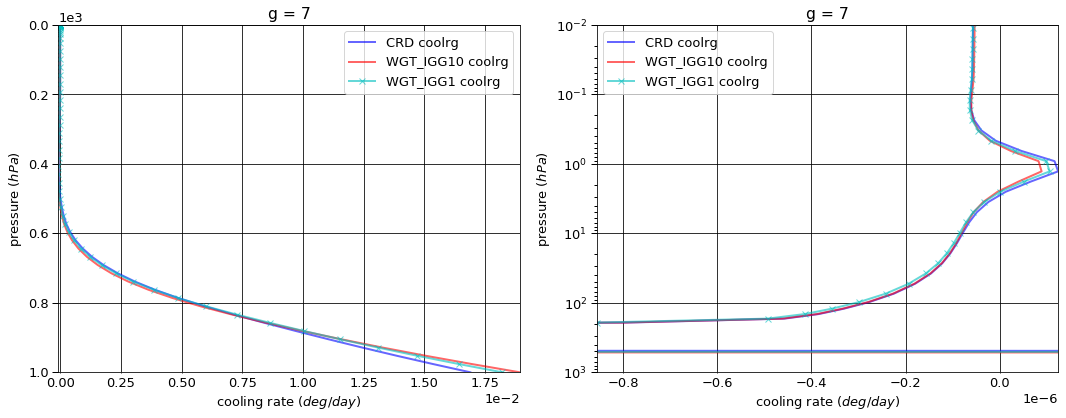

# Figure: cooling rate g-group total

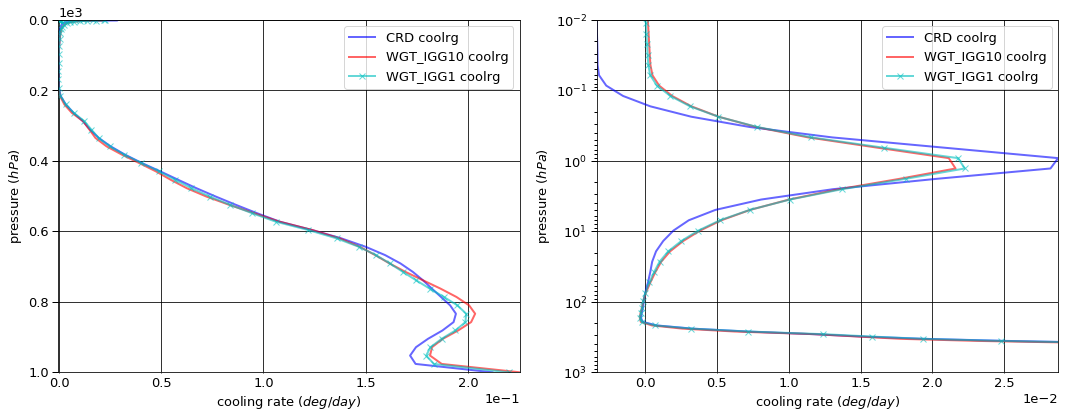

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024690  0.000000 -0.024690
  1013.0   76    -0.168881  0.167316 -0.001565
2 0.0      1     -0.131735  0.000000 -0.131735
  1013.0   76    -0.662861  0.656801 -0.006061
3 0.0      1     -0.551774  0.000000 -0.551774
  1013.0   76    -1.814341  1.797875 -0.016466
4 0.0      1     -2.226258  0.000000 -2.226258
  1013.0   76    -4.743623  4.693406 -0.050217
5 0.0      1     -4.737759  0.000000 -4.737759
  1013.0   76    -7.044017  6.670146 -0.373870
6 0.0      1     -6.312751  0.000000 -6.312751
  1013.0   76    -7.135319  4.074382 -3.060937
7 0.0      1     -2.123777  0.000000 -2.123777
  1013.0   76    -2.186133  0.400979 -1.785154


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023834  0.000000 -0.023834
  1013.0   76    -0.159163  0.157761 -0.001401
2 0.0      1     -0.127773  0.000000 -0.127773
  1013.0   76    -0.634552  0.628965 -0.005587
3 0.0      1     -0.537871  0.000000 -0.537871
  1013.0   76    -1.752952  1.737517 -0.015435
4 0.0      1     -2.182074  0.000000 -2.182074
  1013.0   76    -4.601511  4.559533 -0.041978
5 0.0      1     -4.757739  0.000000 -4.757739
  1013.0   76    -7.000236  6.780058 -0.220178
6 0.0      1     -6.576504  0.000000 -6.576504
  1013.0   76    -7.311386  4.005062 -3.306324
7 0.0      1     -2.231392  0.000000 -2.231392
  1013.0   76    -2.295376  0.413851 -1.881525


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024468  0.000000 -0.024468
  1013.0   76    -0.159163  0.157761 -0.001401
2 0.0      1     -0.127897  0.000000 -0.127897
  1013.0   76    -0.634552  0.628965 -0.005587
3 0.0      1     -0.538080  0.000000 -0.538080
  1013.0   76    -1.752952  1.737517 -0.015435
4 0.0      1     -2.178168  0.000000 -2.178168
  1013.0   76    -4.601511  4.558244 -0.043267
5 0.0      1     -4.740123  0.000000 -4.740123
  1013.0   76    -7.000236  6.730970 -0.269266
6 0.0      1     -6.521629  0.000000 -6.521629
  1013.0   76    -7.311386  4.038116 -3.273270
7 0.0      1     -2.228631  0.000000 -2.228631
  1013.0   76    -2.295376  0.417353 -1.878023


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000855  0.000000  0.000855
  1013.0   76     0.009718 -0.009555  0.000163
2 0.0      1      0.003962  0.000000  0.003962
  1013.0   76     0.028309 -0.027836  0.000474
3 0.0      1      0.013903  0.000000  0.013903
  1013.0   76     0.061389 -0.060358  0.001031
4 0.0      1      0.044183  0.000000  0.044183
  1013.0   76     0.142112 -0.133873  0.008239
5 0.0      1     -0.019980  0.000000 -0.019980
  1013.0   76     0.043781  0.109911  0.153692
6 0.0      1     -0.263753  0.000000 -0.263753
  1013.0   76    -0.176067 -0.069320 -0.245386
7 0.0      1     -0.107615  0.000000 -0.107615
  1013.0   76    -0.109243  0.012872 -0.096370


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000222  0.000000  0.000222
  1013.0   76     0.009718 -0.009555  0.000163
2 0.0      1      0.003838  0.000000  0.003838
  1013.0   76     0.028309 -0.027836  0.000474
3 0.0      1      0.013694  0.000000  0.013694
  1013.0   76     0.061389 -0.060358  0.001031
4 0.0      1      0.048090  0.000000  0.048090
  1013.0   76     0.142112 -0.135162  0.006950
5 0.0      1     -0.002364  0.000000 -0.002364
  1013.0   76     0.043781  0.060824  0.104605
6 0.0      1     -0.208878  0.000000 -0.208878
  1013.0   76    -0.176067 -0.036266 -0.212333
7 0.0      1     -0.104855  0.000000 -0.104855
  1013.0   76    -0.109243  0.016374 -0.092869

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.098656e-03
  1001.112500 75     5.579910e-04
2 0.000312    1     -3.658146e-04
  1001.112500 75     2.162384e-03
3 0.000312    1     -4.783931e-05
  1001.112500 75     5.875593e-03
4 0.000312    1     -5.251072e-05
  1001.112500 75     1.679459e-02
5 0.000312    1     -1.934569e-05
  1001.112500 75     5.561128e-02
6 0.000312    1     -1.989583e-06
  1001.112500 75     1.141194e-01
7 0.000312    1     -5.416277e-08
  1001.112500 75     1.689081e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      6.255160e-05
  1001.112500 75     5.005038e-04
2 0.000312    1     -4.730017e-05
  1001.112500 75     1.995416e-03
3 0.000312    1     -3.584103e-05
  1001.112500 75     5.512345e-03
4 0.000312    1     -3.005392e-05
  1001.112500 75     1.493905e-02
5 0.000312    1     -1.099522e-05
  1001.112500 75     4.726803e-02
6 0.000312    1     -1.080602e-06
  1001.112500 75     1.362665e-01
7 0.000312    1     -5.068040e-08
  1001.112500 75     1.892911e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -9.093527e-05
  1001.112500 75     5.005038e-04
2 0.000312    1     -3.877940e-05
  1001.112500 75     1.995416e-03
3 0.000312    1     -3.675711e-05
  1001.112500 75     5.512345e-03
4 0.000312    1     -3.245153e-05
  1001.112500 75     1.523850e-02
5 0.000312    1     -1.217188e-05
  1001.112500 75     5.221382e-02
6 0.000312    1     -1.240718e-06
  1001.112500 75     1.262185e-01
7 0.000312    1     -5.422281e-08
  1001.112500 75     1.819974e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.161208e-03
  1001.112500 75    -5.748721e-05
2 0.000312    1      3.185145e-04
  1001.112500 75    -1.669677e-04
3 0.000312    1      1.199828e-05
  1001.112500 75    -3.632476e-04
4 0.000312    1      2.245679e-05
  1001.112500 75    -1.855544e-03
5 0.000312    1      8.350469e-06
  1001.112500 75    -8.343245e-03
6 0.000312    1      9.089810e-07
  1001.112500 75     2.214710e-02
7 0.000312    1      3.482364e-09
  1001.112500 75     2.038297e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.007721e-03
  1001.112500 75    -5.748721e-05
2 0.000312    1      3.270353e-04
  1001.112500 75    -1.669677e-04
3 0.000312    1      1.108220e-05
  1001.112500 75    -3.632476e-04
4 0.000312    1      2.005919e-05
  1001.112500 75    -1.556090e-03
5 0.000312    1      7.173802e-06
  1001.112500 75    -3.397461e-03
6 0.000312    1      7.488643e-07
  1001.112500 75     1.209905e-02
7 0.000312    1     -6.004100e-11
  1001.112500 75     1.308921e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.108744,0.000000,-16.108744
1013.0,76,-23.755176,18.460905,-5.294271



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.437189,0.000000,-16.437189
1013.0,76,-23.755176,18.282747,-5.472428



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.358996,0.000000,-16.358996
1013.0,76,-23.755176,18.268926,-5.486250



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.284453e-01,0.000000,-0.328445
1013.0,76,6.000000e-08,-0.178158,-0.178158



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.502528e-01,0.000000,-0.250253
1013.0,76,6.000000e-08,-0.191979,-0.191979


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003586
1001.112500,75,0.212012



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000063
1001.112500,75,0.225411



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000212
1001.112500,75,0.219879



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003523
1001.112500,75,0.013399



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003374
1001.112500,75,0.007867


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008442,0.006700
2,0.031667,0.026712
3,0.084558,0.073792
4,0.218406,0.193706
5,0.300933,0.294683
6,0.277224,0.307781
7,0.078770,0.096626


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.695655e-20
2,2.527212e-21
3,3.766568e-22
4,5.613710e-23
5,8.366699e-24
6,1.246977e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.695655e-20,NaN,0.008442,0.006700,0.008442,0.006700,600.0
2,2.527212e-21,0.14904,0.031667,0.026712,0.040109,0.033412,600.0
3,3.766568e-22,0.14904,0.084558,0.073792,0.124667,0.107205,600.0
4,5.613710e-23,0.14904,0.218406,0.193706,0.343073,0.300910,600.0
5,8.366699e-24,0.14904,0.300933,0.294683,0.644006,0.595593,600.0
6,1.246977e-24,0.14904,0.277224,0.307781,0.921230,0.903374,600.0
7,1.858499e-25,0.14904,0.078770,0.096626,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
